# **Sussy Stock Trades**

#### Prabina Pokharel, Atharva Kulkarni

# **Summary of Findings**

### **Introduction**

This dataset has been maintained by Timothy Carambat as part of the House Stock Watcher project. Each row in this dataset corresponds to one stock trasanction that was carried out by a member of the U.S. House of Representatives. 

There are several features, such as:


`disclosure_date` 
`transaction_date`          
`ticker`              
`asset_description`     
`amount`                    
`representative`

and several more...

For reference, the question we are going to be exploring is:

**Are representatives from the state of Michigan more likely to have an average trade proportion that result in capital gains over 200 usd higher than the rest of the population?**

So in order to be able to answer this question, let's identify a few important columns:

`cap_gains_over_200_usd` 
* Describes if the particular trade resulted in a capital gain of over $200.00

and 

`state` 
*  we will create in the cleaning section



### **Cleaning and EDA**

Here's an overview of our cleaning steps:

* Changing `disclosure_year` and `transaction_date` to pandas datetime object 
  * This was handy to create, as we could simply subtract the two columns to create a new new `non_disclosure_period(days)` column.
* Removed the 'Hon.' out of representatives' names
  * To make it easier to read.
* Added a `state` column, created from `district`
  * Necessary in order to be able to answer our main question!
  * Also useful to create cool aggregates by state!
* Added an `amount_cleaned` column, created from `amount`
  * This was important in order to be able to do any sort of math calculations with relation to amount of the transaction value.


### **Assessment of Missingness**

lhahedasdasd

### **Hypothesis Test**

aliwhdweawdcwd

# **Code**

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# **Cleaning and EDA**

### **Data Cleaning**

A note for this section: we decided to carry out cleaning and EDA before formulating our question, hoping that an interesting question would dawn upon us while doing EDA, so our cleaning will include more steps than necessary than required for eventual hypothesis testing.

In [86]:
df = pd.read_csv('data/all_transactions.csv')
# splitting up so dataframe is displayable in the final pdf :)
display(df.iloc[:, :8].head())
display(df.iloc[:, 8:].head())

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000"
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000"
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000"
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000"
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000"


,representative,district,ptr_link,cap_gains_over_200_usd
0,Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


Let's look at the types of the columns to see which ones may need to have their types changed.

In [87]:
df.dtypes

disclosure_year            int64
disclosure_date           object
transaction_date          object
owner                     object
ticker                    object
asset_description         object
type                      object
amount                    object
representative            object
district                  object
ptr_link                  object
cap_gains_over_200_usd      bool
dtype: object

```disclosure_data``` and ```transaction_date``` can be represented in date time, but they are normal objects right now. 

Let's change them to pandas's ```datetime``` objects

In [88]:
# need to have errors = 'coerce', so some weird data gets set to np.nan
df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], errors = 'coerce')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors = 'coerce')
df.dtypes

disclosure_year                    int64
disclosure_date           datetime64[ns]
transaction_date          datetime64[ns]
owner                             object
ticker                            object
asset_description                 object
type                              object
amount                            object
representative                    object
district                          object
ptr_link                          object
cap_gains_over_200_usd              bool
dtype: object

This next step isn't super important for data analysis, but I'd say it is very important for some readability. If you can't read your data, what will you do??

Let's clean the 'Hon. ' out of every rep's name so it becomes easier to read.

In [89]:
# regex=False to get rid of regex depracated warning
df['representative'] = df['representative'].str.replace('Hon. ', '', regex=False)

Let's create a `state` column so we can do groupby state if we need to in the future.

In [90]:
df['state'] = df['district'].str[:2]
df[['state']].head()

,state
0,NC
1,NC
2,NC
3,NC
4,CA


Now let's deal with the ranges in the ```amount``` column. The ranges are an issue for 2 reasons:

* We can't do math with a range
* It's harder to read

So let's create a new column, ```amount_cleaned```, that consists of the mean of the range given in ```amount```. 

And for values without a range, e.g. '$1,001 -', we'll deal with those after we fill in the ranges with averages.

In [91]:
# create a dictionary to map range values to their average value
mapped_values = {
    '$1,001 - $15,000':8_000.5,
    '$15,001 - $50,000':32_500.5,
    '$50,001 - $100,000':75_000.5,
    '$100,001 - $250,000':175_000.5,

    # place holder so we can calculate values by filling in average
    '$1,001 -':-99,

    '$250,001 - $500,000':375_000.5,
    '$500,001 - $1,000,000':375_000.5,
    '$1,000,001 - $5,000,000':3_000_000.5,

    # place holder so we can calculate values by filling in average
    '$1,000,000 +':-100,

    '$5,000,001 - $25,000,000':15_000_000.5,
    '$1,000 - $15,000':8_000,
    '$15,000 - $50,000':32_000,

    # we aren't giving 50,000,000+ a placeholder here, because we think
    # 50,000,000+ is already too much so let's just keep the average as is.
    '$50,000,000 +':50_000_000,
    '$1,000,000 - $5,000,000':3_000_000,
}

In [92]:
# replace range values with their average value
df['amount_cleaned'] = df['amount'].replace(mapped_values)

Now let's deal with the non-ranges, i.e., '$1,001 -' and '$1,000,000 +'

Let's find the average of ```amount_cleaned``` column when values are above $1,001 and $1,000,000 seperately, and then replace the respective values.

In [93]:
avg_above_1001 = round(df.loc[df['amount_cleaned'] >= 1_001]['amount_cleaned'].mean(), 2)
avg_above_1_mil = round(df.loc[df['amount_cleaned'] >= 1_000_000]['amount_cleaned'].mean(), 2)

avg_above_1001, avg_above_1_mil

(53267.76, 6163265.79)

In [94]:
# replace -99, which maps to '$1,001 -' in 'amounts' with avg_above_1001
df['amount_cleaned'] = df['amount_cleaned'].replace({-99: avg_above_1001})

# replace -100, which maps to '$1,000,000 +' in 'amounts' with avg_above_1_mil
df['amount_cleaned'] = df['amount_cleaned'].replace({-100: avg_above_1_mil})

# let's make sure the -99 and -100 values are gone!
(-99 or -100) in df['amount_cleaned'].value_counts()

False

In [95]:
# let's make sure our newly added column is of type float
df.dtypes[-1]

dtype('float64')

What if we wanted to examine how long it takes for reps to disclose their trade? Let's create a new column called ```non_disclosure_period(days)```.

Our previous work of converting `disclosure_date` and `transaction_date` to `datetime` objects will also come in handy here, since we can simply subtract the 2 columns.

In [96]:
# assign a new column 'non_disclosure_period(days)' to be difference of 'disclosure_date' and 'transaction_date'
df['non_disclosure_period(days)'] = (df['disclosure_date'] - df['transaction_date']).dt.days
df[['non_disclosure_period(days)']].head()

,non_disclosure_period(days)
0,7.0
1,21.0
2,24.0
3,6.0
4,17.0


Let's see if there are any weird values in this new column.

In [97]:
df[df['non_disclosure_period(days)'] < 0].shape[0]

13

There are 13 transactions where non disclosure days are negative. We will exclude those.

This concludes our data cleaning section.

### **EDA - Univariate Analysis**

Note: ```value_counts()``` will help us understand the values of a column by showing us how many times each entry occurs.

Let's explore the ``disclosure_year`` columm first.

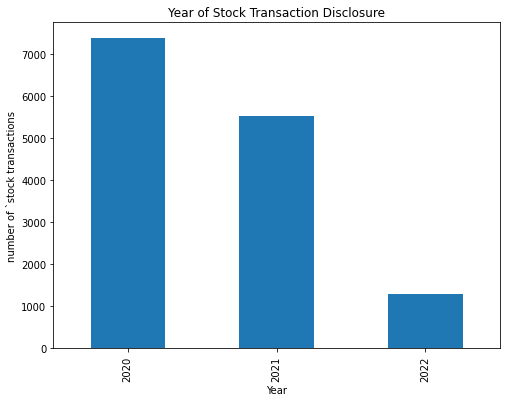

In [98]:
# first call .value_counts(), then .plot(), so graph is easier to read
df['disclosure_year'].value_counts().plot(kind = 'bar', \
    title = 'Year of Stock Transaction Disclosure', \
    xlabel = 'Year', ylabel = 'number of `stock transactions', figsize=(8,6));

Clearly **2020** was the most popular year in this data set. This doesn't mean that the reps just traded more in 2020 than in 2021 or 2022, they probably just have not disclosed trades from those two years yet.

Now let's look at the ```ticker``` column. There are too many individiual tickers (abbreviations used to uniquely identify shares of a particular stock), so we will only look at the top 20.

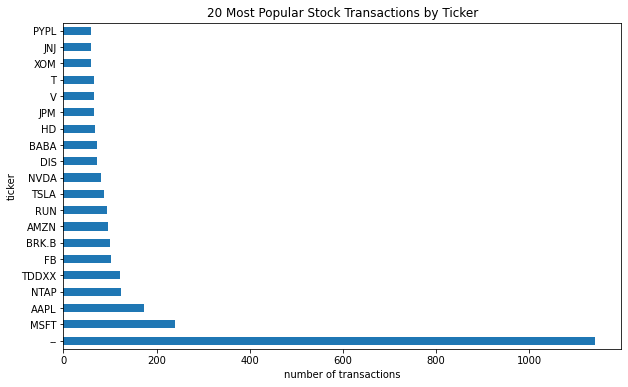

In [99]:
df['ticker'].value_counts()[:20].plot(kind = 'barh', figsize=(10,6))
plt.title('20 Most Popular Stock Transactions by Ticker')
plt.ylabel('ticker')
plt.xlabel('number of transactions')
plt.show()

Clearly, the most popular stock trades are in tech:
* Microsoft
* Apple
* NetApp
* FaceBook (Meta)
* Amazon
* Tesla
* and so on...

But there is even a Fed Fund:
*  BLF FedFund (TDDXX)


**Surprised rich people are investing in fed funds?**

**Hey, maybe the old people in the House of Representatives *really do care***
**about their retirement funds!**


The biggest surprise, however, is the most popular ticker, '--', which isn't even a stock. What is '--'? Let's clean that up and convert to `np.nan`.

In [100]:
df['ticker'] = df['ticker'].replace({'--': np.nan})

Let's make sure the `--` characters are gone.

In [101]:
# resulting dataframe should have 0 rows, .shape[0] should be equal to 0
df[df['ticker'] == '--'].shape[0] == 0

True

Now let's look at the ```amount_cleaned``` column, to see how much of that 💰💸🤑 reps bring in.

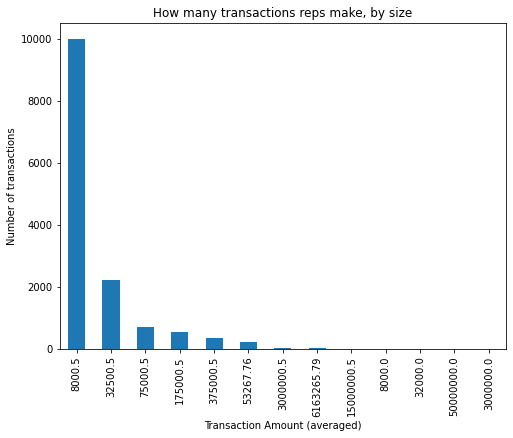

In [102]:
# first call .value_counts(), then .plot(), so graph is easier to read
df['amount_cleaned'].value_counts().plot(kind = 'bar', \
    title = 'How many transactions reps make, by size', ylabel = 'Number of transactions', \
    xlabel = 'Transaction Amount (averaged)', figsize=(8,6));

Wow! Such an overwhelming majority of stock trades are averaged out to $8,000, that the graph gets stretched vertically so much that we cannot even estimate how many transactions are done for any transaction above $53267.76.

### **EDA - Bivariate Analysis**

We want to see whether reps have many counts of capital gains of over $200 or few. Let's find that out by grouping ```amount_cleaned``` and ```cap_gains_over_200_usd```.

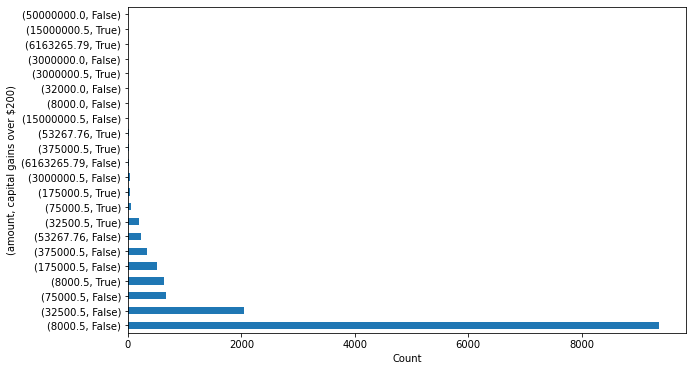

In [103]:
df[['amount_cleaned', 'cap_gains_over_200_usd']].value_counts().plot(kind = 'barh', figsize=(10,6))
plt.xlabel("Count")
plt.ylabel("(amount, capital gains over $200)")
plt.show()

Let's see if the `non_disclosure_period(days)` column has any correlation with `amount_cleaned`.

Does a bigger stock transaction (higher `amount_cleaned`) lead to a longer `non_disclosure_period(days)` period? Let's find out.

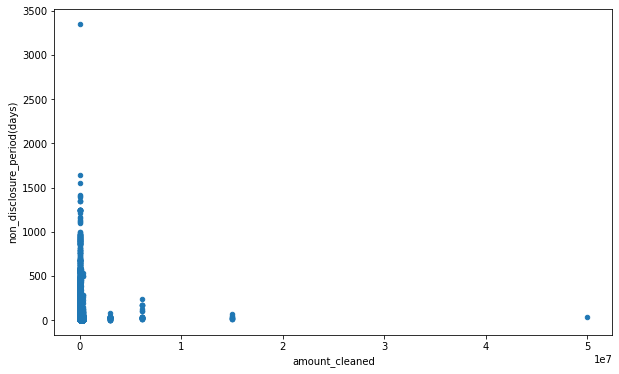

In [104]:
relevant_non_disclosure_periods = df.loc[(df['non_disclosure_period(days)'] > 0)]\
    [['amount_cleaned', 'non_disclosure_period(days)']]
relevant_non_disclosure_periods.plot(kind='scatter', x='amount_cleaned', \
    y = 'non_disclosure_period(days)', figsize=(10,6));

Before analyzing anything, an important point: this graph seems kinda weird right? Why are all the points jumbled around a few x values?

Well, this is the result of replacing a range with the average of the range.

As most of our data is seems to be less than trade transaction amount of 2 million, let's zoom in on its left to see if we notice anything.

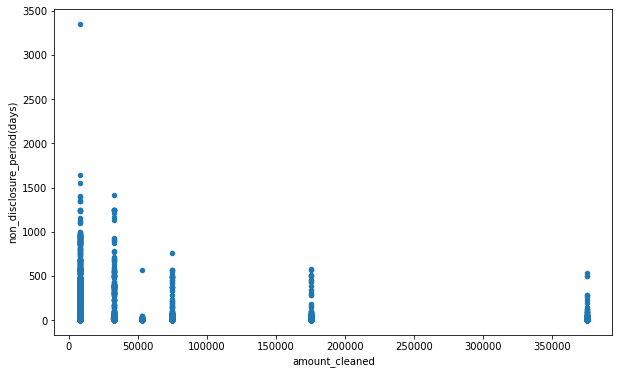

In [105]:
closer_look = relevant_non_disclosure_periods[relevant_non_disclosure_periods['amount_cleaned'] < 2_000_000]
closer_look.plot(kind='scatter', x='amount_cleaned', y = 'non_disclosure_period(days)', figsize=(10,6));

Huh!

We notice that there doesn't seem to be much relationship between transaction amount and the non disclosure period. Our hypothesis was that reps that have invested more in trades delay disclosing it, **but here we see the opposite**, where, if the transaction was high, they seem to be disclosing it sooner than if the transaction was low.

This makes sense, they probably don't want to get into legal trouble. They are politicians after all, and they will do anything to make sure they get reelected. I'm sure the headlines of

 *Rep. X. arrested after failing to disclose a trade of $5,000,000.*

 won't be great for their political career.

### **Interesting Aggregates / Pivot Tables**

Let's find out if there are any reps with a 100% `cap_gains_over_200_usd` proportion score.

In [106]:
(
    df.pivot_table(index = 'representative', values = 'cap_gains_over_200_usd')
    .sort_values(by='cap_gains_over_200_usd', ascending=False)
)

,cap_gains_over_200_usd
representative,
Patrick T. McHenry,1.000000
Mr. TJ John (Tj) Cox,1.000000
Tim Burchett,1.000000
Mr. Peter Meijer,0.902256
Bradley S. Schneider,0.777778
...,...
Harold Dallas Rogers,0.000000
Harley E. Rouda,0.000000
Gus M. Bilirakis,0.000000


It looks like Reps. Patrick T. McHenry, Mr. TJ John (Tj) Cox, and Tim Burchett are pros, with a 100% ```cap_gains_over_200_usd``` proportion score. But, are they really?"

In [107]:
df[
    (df['representative'] == 'Patrick T. McHenry') |
    (df['representative'] == 'Mr. TJ John (Tj) Cox') |
    (df['representative'] == 'Tim Burchett')
]

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state,amount_cleaned,non_disclosure_period(days)
56,2020,2020-09-22,2020-08-17,NaN,NaN,Metallic Minerals Corp.,sale_partial,"$100,001 - $250,000",Mr. TJ John (Tj) Cox,CA21,https://disclosures-clerk.house.gov/public_dis...,True,CA,175000.5,36.0
10854,2021,2021-01-10,2020-11-19,NaN,D,Sale of shares in Dominion Energy Inc.,sale_full,"$15,001 - $50,000",Patrick T. McHenry,NC10,https://disclosures-clerk.house.gov/public_dis...,True,NC,32500.5,52.0
13381,2020,2020-02-26,2020-02-12,NaN,DENN,Denny's Corporation,sale_full,"$1,001 - $15,000",Tim Burchett,TN02,https://disclosures-clerk.house.gov/public_dis...,True,TN,8000.5,14.0


Upon further review, it seems that they each have only traded once so we don't have enough data to conclude that they are really pros at stock trading. 

Ok, that was a flop.

Here's a new one to aggregate:
**Which state has the highest average number of trades that result in capital gains over $200?**

In [108]:
(
    df.pivot_table(index = 'state', values = 'cap_gains_over_200_usd')
    .sort_values(by = 'cap_gains_over_200_usd', ascending=False)
    .head()
)

,cap_gains_over_200_usd
state,
MI,0.772871
SC,0.379310
NY,0.280702
ID,0.222222
LA,0.222222


Michigan! With a pretty mind blowing result of 77% 🤯

Does the value of 77% seem *sussy?* Well, we do. (Yes, this is foreshadowing for our Hypothesis Testing)

**Note:** The first that may come to mind is that Michigan may have had a high ```cap_gains_over_200_usd``` value for relatively small trades, in the $8000.5 category, and low numbers in the rest. This would have induced Simpson's paradox. But as shown below, we checked with another pivot table, and it is really the case that Michigan has high ```cap_gains_over_200_usd``` values for *all* amount categories. 

Let's look at `non_disclosure_period(days)` values indexed by the stock transaction amount itself, for each type of exchange.

In [109]:
df.pivot_table(index='amount_cleaned', values='non_disclosure_period(days)', columns='type')

type,exchange,purchase,sale_full,sale_partial
amount_cleaned,,,,
8000.00,NaN,NaN,19.000000,19.000000
8000.50,149.081967,65.273784,73.570919,57.616108
32000.00,NaN,NaN,19.000000,19.000000
32500.50,35.285714,49.260524,44.978177,80.050562
53267.76,19.000000,10.752688,39.545455,13.031746
75000.50,40.875000,42.727506,42.405738,63.606557
175000.50,40.500000,25.249097,53.600917,40.725000
375000.50,33.333333,27.622754,37.950311,47.933333
3000000.00,NaN,NaN,23.000000,NaN


This table is confusing, so let's look at just the means of each of the columns.

In [110]:
df.pivot_table(index='amount_cleaned', values='non_disclosure_period(days)', columns='type').mean()

type
exchange        51.582288
purchase        40.964468
sale_full       38.550314
sale_partial    39.663331
dtype: float64

For some reason, or just sheer random chance, exchanges take on average almost 12 days longer to be disclosed than purchases, full sales, and partial sales. Interesting 🤔🤔

This concludes our EDA section.

# **Assessment of Missingness**

hehehhehehehehheeee

# **Hypothesis Testing**

The question we've decided to explore is the case of *why are Michigan reps so damn good at trading stocks?*

Here's a little bit of background again to refresh your memory.

In our interesting aggregates / pivot tables section, we wanted to answer:
**Which state has the highest average number of trades that result in capital gains over $200?**

In [80]:
(
    df.pivot_table(index = 'state', values = 'cap_gains_over_200_usd')
    .sort_values(by = 'cap_gains_over_200_usd', ascending=False)
    .head()
)

,cap_gains_over_200_usd
state,
MI,0.772871
SC,0.379310
NY,0.280702
ID,0.222222
LA,0.222222


**Formalized...**

* **Question:**

The reps from the state of Michigan have a 77% of trades that result in the ```cap_gains_over_200_usd``` column have a True value. 

Is this just by chance, or are the representatives from some states, like  *The Great Lakes State*, just that damn much better at trading then representatives from other states?

* **Null hypothesis:** Reps from Michigan *are not* more likely to have an average trade proportion that result in capital gains over 200 usd higher than the rest of the population.

* **Alternative Hypothesis:** Reps from Michigan *are* more likely to have an average trade proportion that result in capital gains over 200 usd higher than the rest of the population.

* **Test statistic:** Difference of means between average value of `cap_gains_over_200_usd` column for Michigan reps vs average value of `cap_gains_over_200_usd` column for non-Michigan reps.
  * Difference of means is appropriate here because we have numerical/quantitiative data

* **Significance level:** 1%

##### There's an easy solution to this problem - **Permutation Testing!**

We're choosing permutation testing over hypothesis testing because we are given *2* observed samples (versus the only *one* that hypothesis testing works on). One group is all trades from reps from Michigan, and the other group are all trades that are not from reps from Michigan. We need to see if they are they fundamentally different, or could they have been generated by the same process?

Let's begin the permutation testing. 

First, let's find the observed test statistic: difference in means.

In [124]:
# let's only choose the columns we need 
ptest_df = df[['state', 'cap_gains_over_200_usd']]

# seperate into 2 groups
ptest_df_MI = ptest_df.loc[ptest_df['state'] == 'MI']
ptest_df_NOTMI = ptest_df.loc[ptest_df['state'] != 'MI']

# calculate difference of means
observed_diff_means = ptest_df_MI['cap_gains_over_200_usd'].mean() - \
                        ptest_df_NOTMI['cap_gains_over_200_usd'].mean()
observed_diff_means

0.7210881633608198

So the reps from Michigan have an average value of `cap_gains_over_200_usd` substantially higher than non-Michigan reps, by about 72%.

Now let's run the permutation test 500 times.

In [140]:
diff_means = []
N = 500
for _ in range(N):

    # shuffle the cap_gains_over_200_usd column
    shuffled_gains = (
        ptest_df['cap_gains_over_200_usd']
        .sample(frac=1)
        # we need to reset_index w/ drop=True otherwise the old index values will exist
        .reset_index(drop=True)
    )

    # assign a new dataframe with the shuffled column
    ptest_df_shuffled = (
        ptest_df.assign(**{'shuffled_cap_gains_over_200_usd': shuffled_gains})
    )

    # Michigan only values
    MI_only = (
        ptest_df_shuffled.loc[ptest_df_shuffled['state'] == 'MI']
    )

    # NON-Michigan only values
    not_MI = (
        ptest_df_shuffled.loc[ptest_df_shuffled['state'] != 'MI']
    )

    # compute difference in means by subtracting MI-only group's mean with
    # NON-MI-only group's mean.
    test_stat = (
        MI_only['shuffled_cap_gains_over_200_usd'].mean() - \
            not_MI['shuffled_cap_gains_over_200_usd'].mean()
    )
    diff_means.append(test_stat)

Now let's calculate the p-value!

The p-value represents what proportion of our `observed_diff_means` list had more extreme values than our observed test-statistic, `diff_means`.

In [147]:
p_val = np.mean(diff_means >= observed_diff_means)
p_val

0.0

**0!**

So this means that our result is **highly significant**, and we can reject the null hypothesis since our p-value (0.0) is lower than our significance level (0.01).

I.E., Reps from Michigan *did indeed* have an average trade proportion that resulted in capital gains over 200 usd *higher* than the rest of the population, and this was **not due by chance**. 

If it was only due by chance, our p-value would not be so low, and we would not be rejecting the null hypothesis.